# Progetto di Data and Web mining

Matteo Spanio, A.A. 2021/2022

# Esplorazione dei dati

Il dataset fornito per il [Zillow Prize](https://www.kaggle.com/competitions/zillow-prize-1/overview) si presenta le caratteristiche di alcune case vendute nella zona della California circostante a Los Angeles nel 2016 e 2017.

Il valore che si chiede di predirre nella sfida è il *logerror*, cioè la differenza tra il logaritmo del valore della proprietà stimato dall'algoritmo Zestimate e il logaritmo del valore effettivo alla vendita della casa, quindi logerror negativi indicano che il valore della casa è stato sottostimato (o una serie di circostanze ha fatto sì che la casa venisse venduta a un prezzo maggiore di quello atteso), viceversa per i valori positivi:

$$
logerror = \log(Zestimate) - \log(SalePrice)
$$

Innanzitutto diamo uno sguardo ai dati del 2016:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

import Zillow.data as zd

# read files containing features
raw_2016_features = zd.get_features(2016)

# read target data
raw_logerr_2016 = zd.get_y(2016)
    
# merge everything in a single dataframe
df = zd.merge_x_y(raw_2016_features, raw_logerr_2016)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 0 to 90149
Data columns (total 60 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      90150 non-null  int64  
 1   logerror                      90150 non-null  float64
 2   transactiondate               90150 non-null  object 
 3   airconditioningtypeid         28748 non-null  float64
 4   architecturalstyletypeid      260 non-null    float64
 5   basementsqft                  43 non-null     float64
 6   bathroomcnt                   90150 non-null  float64
 7   bedroomcnt                    90150 non-null  float64
 8   buildingclasstypeid           16 non-null     float64
 9   buildingqualitytypeid         57284 non-null  float64
 10  calculatedbathnbr             88974 non-null  float64
 11  decktypeid                    658 non-null    float64
 12  finishedfloor1squarefeet      6850 non-null   float64
 13  c

Si nota a colpo d'occhio che i dati sono sparsi, cioè diverse colonne hanno un elevato numero di `null-values`, probabilmente alcune feature risulteranno inutilizzabili per via di queste mancanze, inoltre dai nomi di alcune caratteristiche sembra che ci sia una certa ridondanza: si notino le colonne `finishedfloor1squarefeet`, `calculatedfinishedsquarefeet`, `finishedsquarefeet12`, `finishedsquarefeet13`, `finishedsquarefeet15`, `finishedsquarefeet50`, `finishedsquarefeet6`; nonostante Zillow proponga una [descrizione delle feature](https://www.kaggle.com/competitions/zillow-prize-1/data), non è facile cogliere la differenza tra le suddette colonne. In linea di massima [questa conversazione](https://www.kaggle.com/c/zillow-prize-1/discussion/34168) chiarisce che esistono diverse feature relative allo stesso argomento e quelle che iniziano con `calculated` consistono in una sintesi delle altre, infatti sono quelle utilizzate dall'algoritmo Zestimate.

__serve?__

Di seguito si riportano le descrizioni per disambiguare le voci che sembrano simili, tralasciando invece le variabili che hanno già un nome autoesplicativo e non ridondante:

1. il primo gruppo riguarda la superficie abitabile della casa
|Feature | Description |
|---|---|
| `basementsqft`|  Finished living area below or partially below ground level |
| `finishedfloor1squarefeet`|  Size of the finished living area on the first (entry) floor of the home |
| `calculatedfinishedsquarefeet`|  Calculated total finished living area of the home  |
| `finishedsquarefeet6`| Base unfinished and finished area |
| `finishedsquarefeet12`| Finished living area |
| `finishedsquarefeet13`| Perimeter  living area |
| `finishedsquarefeet15`| Total area |
| `finishedsquarefeet50`| Size of the finished living area on the first (entry) floor of the home |

In [3]:
duplicates = raw_logerr_2016[raw_logerr_2016.duplicated(["parcelid"],keep=False)]
print("Le righe duplicate sono:")
duplicates.info()

Le righe duplicate sono:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 249 entries, 496 to 80674
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   parcelid         249 non-null    int64  
 1   logerror         249 non-null    float64
 2   transactiondate  249 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 7.8+ KB


In [4]:
duplicates.head(10)

parcelid  logerror transactiondate
496   13850164   -0.1567      2016-01-05
497   13850164   -0.0460      2016-06-29
781   14677191   -0.3682      2016-01-06
782   14677191   -0.0845      2016-09-12
813   11005771   -0.0131      2016-01-06
814   11005771    0.0545      2016-06-17
967   11183209   -0.0481      2016-01-07
968   11183209   -0.0070      2016-09-14
1164  11554091   -0.1696      2016-01-07
1165  11554091   -0.0954      2016-07-05

<div class='alert alert-info'>
    
**NB**: nei file con i valori dei logerror si presentano più volte gli stessi `parcelid` con date di vendita diverse (cioè la stessa casa è stata venduta più volte in diversi momenti dell'anno). In questo bisogna valutare se sia il caso di rimuovere gli id duplicati in quanto il contest chiede di effettuare previsioni sull`errore in base al mese, quindi se lo stesso lotto è stato venduto più volte in date diverse potrebbe essere un dato rilevante.

</div>

# Analisi grafiche

Cercando sulla mappa le coordinate delle proprietà si osserva che sono tutte nello stato della California, per la precisione, da Nord verso Sud, nelle contee di Ventura, Los Angeles e Orange (le contee americane sono una divisione dello stato in aree amministrative, come le regioni in Italia).
Osservando i numeri in `regionidcounty` si può andare in cerca a quali contee corrispondono 

In [5]:
df['CountyName'] = df['regionidcounty'].replace({1286.: 'Ventura',
                              2061.: 'Orange',
                              3101.: 'Los Angeles'})

A questo punto può essere utile visualizzare le distribuzioni e le correlazioni tra i dati dei dati:

In [6]:
sns.pairplot(df, hue="CountyName", diag_kind="auto", corner=True);

Il grafico disegnato dà una buona rappresentazione delle relazioni tra le variabili nel dataset, e mette in luce diversi fattori:

1. molte feature sono completamente assenti per zone:
    - `airconditioningtypeid` e `architecturalstyletypeid` mancano a Ventura
    - `basementsqft`
    
    
2. i dati categorici non sono difficilmente interpretabili in questa rappresentazione

3. alcune feature inseriscono evidentemente dati non corretti: si vede che tutti i record di Los Angeles hanno il valore `roomcnt` a 0 

Visto che il campo `logerror` ha una distribuzione fortemente centrata sulla media con una bassa varianza, un buono stimatore da tenere come riferimento di base durante l'indagine è la media dei `logerror`.

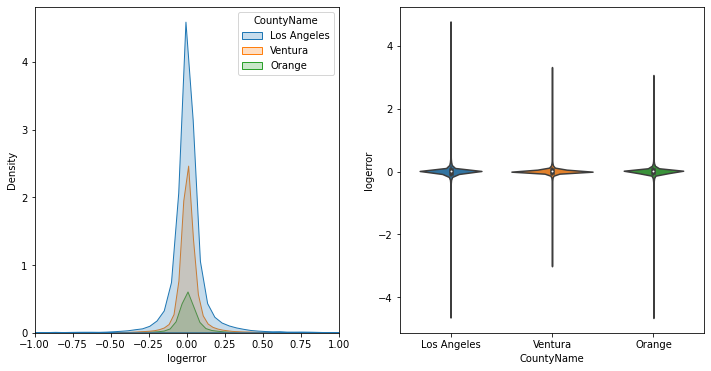

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))

sns.kdeplot(data=df, x="logerror", hue="CountyName", fill=True, ax=ax1)
ax1.set_xlim(-1, 1)
sns.violinplot(x="CountyName", y="logerror", data=df, ax=ax2);

In [17]:
from Zillow.models import Mean
from Zillow.data import split_x_y

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

X, y = split_x_y(df)

model = Mean()

mae_list = []

for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i+40)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    mae_list.append( mean_absolute_error(y_true=y_test, y_pred=y_hat) )

print(f'mean absolute error based on logerror mean is {np.mean(mae_list):.5}')

mean absolute error based on logerror mean is 0.067891


In [20]:
df.to_csv('./Zillow/dataset/2016_data_exploration.csv')